# Take Home Test Instructions

You are being provided with a single compressed csv file with the following fields :

- browser : the browser the campaign was provided on
- visiting_time : the amount of time on the campaign site
- total_amount_due : their account balance at time of visiting
- previous_payment_amount : the amount of the last payment they made
- previous_visitor : whether or not we have evidence that they have been shown the campaign before
- day_of_week : the day of the week of viewing
- campaign : which campaign they were shown
- converted: whether or not they finished the sign up process after the campaign
- traffic_source: where they were when funneled to the campaign. This value is set after the campaign has been shown as part of the signup process. It is not possible for us to detect this prior to sign up at this time.


The experiment describes a series of marketing campaigns that have the goal of converting an interaction into a new user of a service we're currently starting to offer at the company.

Three different marketing campaigns were applied at random to a population of visitors to our company. Each visitor was selected at random and had a different entry route to an interaction (web, mobile, in store), was shown a marketing campaign selected at random, and then asked if they wished to sign up for the service.


Generate a short report (< 2 pages including figures) that analyzes and explores the data set in order to answer the following question :

How would you utilize the results of this experiment in order maximize conversion ?

Please send back the report along with any code (or links to remote repositories) within 7 days.

## Assumptions

#### Random Variables:
1. Marketing Campaign (A, B, C) shown to visitor
2. Population of visitors to company
3. Selected visitor from population

$\implies$ Assumption: the visitor's entry route (i.e. traffic_source) is also random since this is controlled by the visitor being selected at random

$\implies$ Assumption: the visitor's browser choice is also random since this is controlled by the visitor being selected at random

$\implies$ Assumption: the day_of_week is random since this is controlled by the visitors

## Major Questions: 
<ol><li>Which feature/features correlate the strongest with the classifier (convert/not convert)?</li>
    <li>What is the best combination of features that accurately predicts the output (convert/not convert)?</li>
</ol>

#### Process: 
<ol><li>Exploratory Data Analysis. </li>
    <ul><li>Plot histograms and distrbution plots to visualize trends. Specifically looking for trends between:</li>
        <ul><li>feature-and-feature</li><li>feature-and-conversion</li></ul></ul>
    <li>Feature Engineering.</li>
    <li>Predictive Model Analysis Using Decision Tree.</li>
</ol>

In [249]:
# Import all packages
%matplotlib inline

import os
import gc
import pydotplus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

np.random.seed(42)

In [250]:
# Read in data
df = pd.DataFrame(pd.read_csv('results.csv'))

# Review features
df.keys()

Index(['browser', 'visiting_time', 'total_amount_due',
       'previous_payment_amount', 'previous_visitor', 'day_of_week',
       'campaign', 'converted', 'traffic_source'],
      dtype='object')

<hr>

# <u>Step 1: Exploratory Data Analysis</u>

#### Initial view of dataset overall (head, tail, sample, shape, describe)

In [251]:
# Review top 5 to get idea of data set
df.head()

,browser,visiting_time,total_amount_due,previous_payment_amount,previous_visitor,day_of_week,campaign,converted,traffic_source
0,Chrome,408.561947,2514.980300,210.646360,0,Thur,A,0,mobile
1,Chrome,411.236035,2127.218600,124.013649,0,Thur,A,0,mobile
2,Chrome,429.661970,1958.818180,220.467136,0,Thur,A,0,mobile
3,Chrome,375.763726,1718.324561,206.429885,0,Thur,A,0,mobile
4,Chrome,426.779222,2242.363328,154.405074,0,Thur,A,0,mobile


In [252]:
# Review last 5 for good measure
df.tail()

,browser,visiting_time,total_amount_due,previous_payment_amount,previous_visitor,day_of_week,campaign,converted,traffic_source
59995,Firefox,411.932570,2658.592601,284.762135,0,Thur,C,1,in_store
59996,Firefox,457.538609,3573.903911,354.338124,0,Thur,C,0,in_store
59997,Firefox,602.088779,4269.893360,291.415535,0,Thur,C,0,in_store
59998,Firefox,481.300181,3458.469419,273.395332,0,Wed,C,1,in_store
59999,Firefox,610.340586,4360.412066,254.626466,0,Thur,C,0,in_store


In [253]:
# Show me a sample of 20 to better understand the data's randomness
df.sample(20)

,browser,visiting_time,total_amount_due,previous_payment_amount,previous_visitor,day_of_week,campaign,converted,traffic_source
12628,Safari,416.836337,2176.025127,309.852142,0,Wed,A,0,mobile
37730,InternetExplorer,396.217191,3771.791806,238.902575,0,Wed,B,0,web
39991,Chrome,408.167544,3742.962932,365.201136,0,Mon,B,0,in_store
8525,Firefox,497.596332,3994.439889,196.982087,0,Friday,A,0,web
8279,Chrome,457.513071,3564.386820,205.831273,0,Thur,A,0,web
51012,InternetExplorer,639.352558,3032.971148,164.844394,0,Thur,C,0,mobile
14871,Safari,492.353147,2061.165233,309.406094,0,Sat,A,0,mobile
15127,Chrome,471.607283,2323.021832,317.388763,0,Friday,A,0,mobile
9366,Firefox,461.212029,3190.100042,185.956985,0,Thur,A,1,web
33322,Firefox,326.694719,2021.323977,333.821432,0,Thur,B,0,mobile


In [254]:
# How many samples and how many features? 
df.shape

(60000, 9)

In [255]:
df.describe(include='all')

,browser,visiting_time,total_amount_due,previous_payment_amount,previous_visitor,day_of_week,campaign,converted,traffic_source
count,60000,60000.000000,60000.000000,60000.000000,60000.000000,60000,60000,60000.000000,60000
unique,4,NaN,NaN,NaN,NaN,7,3,NaN,3
top,Firefox,NaN,NaN,NaN,NaN,Thur,C,NaN,mobile
freq,27346,NaN,NaN,NaN,NaN,24621,20000,NaN,42000
mean,NaN,504.156182,2832.330386,243.988172,0.018417,NaN,NaN,0.130567,NaN
std,NaN,117.686545,662.556377,75.799250,0.134454,NaN,NaN,0.336929,NaN
min,NaN,100.000000,1000.000000,50.000000,0.000000,NaN,NaN,0.000000,NaN
25%,NaN,422.292518,2295.395938,178.962198,0.000000,NaN,NaN,0.000000,NaN
50%,NaN,484.862857,2636.425712,241.672570,0.000000,NaN,NaN,0.000000,NaN
75%,NaN,577.709623,3418.290426,298.647346,0.000000,NaN,NaN,0.000000,NaN


## What percentage of the samples converted vs. did not?

Text(0, 0.5, '')

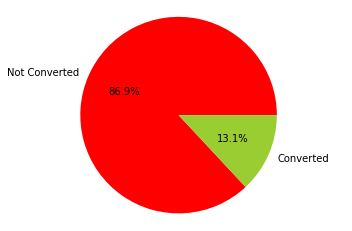

In [256]:
fig, ax = plt.subplots(1, 1)
ax.pie(df.converted.value_counts(),autopct='%1.1f%%', labels=['Not Converted','Converted'], colors=['r', 'yellowgreen'])
plt.axis('equal')
plt.ylabel('')

In [257]:
# Check pie chart accuracy
print(f'Count:\n{df.converted.value_counts()}\n\nPercent:\n{df.converted.value_counts(1)}')

Count:
0    52166
1     7834
Name: converted, dtype: int64

Percent:
0    0.869433
1    0.130567
Name: converted, dtype: float64


<hr>

## <u>Data Exploration - Discrete Features</u>

#### 1. What is the count of each discrete feature?
#### 2. What is the count of each discrete feature's value that produced a conversion (i.e. Browser=firefox)?
#### 3. What proportion of the overall feature does that value represent?

In [258]:
def cvrDoubleHist(v, x, t, l):
    fig, ax1 = plt.subplots(1, 1, sharex = True, figsize=(6,3))
    ax1.hist([x[df.converted==1],x[df.converted==0]], bins=v, color=['g','r'],alpha=0.5)
    ax1.set_title(t)
    ax1.set_xlabel(l)
    ax1.set_ylabel('# of Conversions')
    
def cvrSingleHist(v, x, t, l):
    fig, ax1 = plt.subplots(1, 1, sharex = True, figsize=(6,3))
    ax1.hist(x[df.converted==1], bins=v*2, color='g',alpha=0.5)
    ax1.set_title(t)
    ax1.set_xlabel(l)
    ax1.set_ylabel('# of Conversions')

browser count: 
Firefox             27346
Chrome              21686
InternetExplorer     5970
Safari               4998
Name: browser, dtype: int64

% of total browser: 
Firefox             45.58
Chrome              36.14
InternetExplorer     9.95
Safari               8.33
Name: browser, dtype: float64

cnv cnt by browser count:
Firefox             4055
Chrome              2454
InternetExplorer     818
Safari               507
Name: browser, dtype: int64

% cvr of each browser
Firefox             51.76
Chrome              31.32
InternetExplorer    10.44
Safari               6.47
Name: browser, dtype: float64
------------------------------
day_of_week count: 
Thur      24621
Wed       15665
Friday    13364
Tues       3281
Sat        2629
Mon         266
Sun         174
Name: day_of_week, dtype: int64

% of total day_of_week: 
Thur      41.04
Wed       26.11
Friday    22.27
Tues       5.47
Sat        4.38
Mon        0.44
Sun        0.29
Name: day_of_week, dtype: float64

cnv cnt by day_o

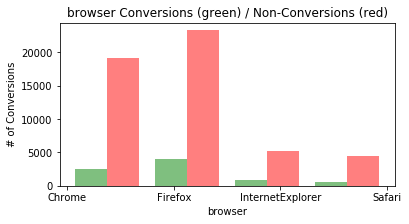

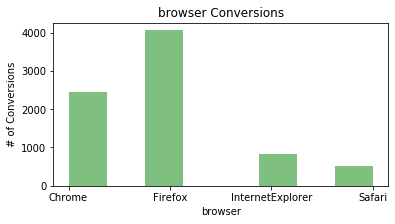

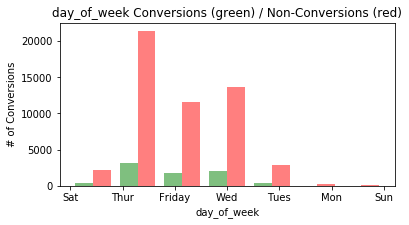

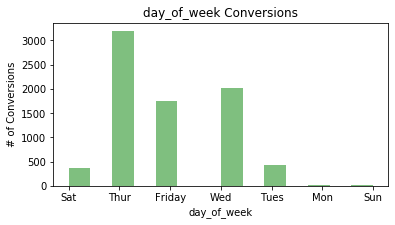

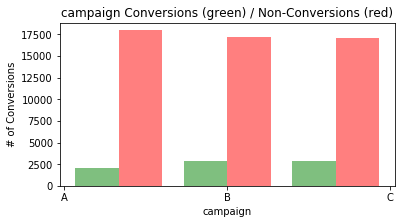

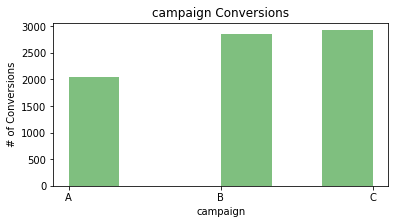

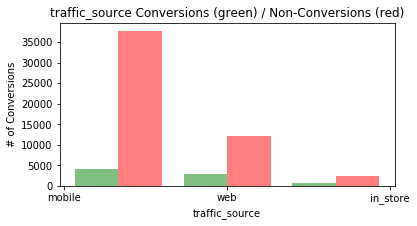

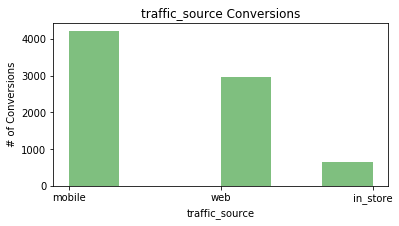

In [259]:
# Value counts of each features static entires.
discrete = [df.browser, df.day_of_week, df.campaign, df.traffic_source]

for x in discrete:
    name = x.name
    vc = x.value_counts()
    f_vc = x[df.converted==1].value_counts()
    fv_prop = round(f_vc/sum(f_vc)*100,2)
    print(f'{name} count: \n{vc}\n\n% of total {name}: \n{round(vc/sum(vc)*100, 2)}\n\ncnv cnt by {name} count:\n{f_vc}\n\n% cvr of each {name}\n{fv_prop}\n------------------------------')
    cvrDoubleHist(len(vc), x, f'{name} Conversions (green) / Non-Conversions (red)', name)
    cvrSingleHist(len(vc), x, f'{name} Conversions', name)

## <u>Data Analysis - Discrete Features</u>

## browser
<p>Firefox and Chrome are the top 2 browsers with the most and 2nd most conversions. Since visitors are selected at random, we've made the assumption (above) that thee browser choice is also random within our dataset since we cannot control the browser choice and are taking the visitor at random. </p>
    
<p>Firefox and Chrome also happen to be the 2 most popular products on the market. Looking at the above browser counting data, we see that these browser are the two most-used browsers in our dataset making the relationship between browser-type and conversion rate possibly correlated to the fact that Safari and IE are less used therefore reducing the opportunity for these browsers to produce conversions.</p>
    
<p>If more people use these products, its likely the case that people prefer using them. Preference indicates that visitors like using these browsers, which implies some form of ease-of-use or positive interaction. Positive feelings while browsing directly influences consumer buying behavior positively. Moving forward, I would recommend disproportionaly focusing marketing budget and marketing campaigns on visitors using these browsers. This will maximize possible conversion per marketing dollar spent.</p>

<p>Speaking from a purely statistical perspective, the results are correlative and possible anomolous; We must temper action with widsom and avoid throwing ALL marketing at 2 browsers. We also must temper action with practicality; practically speaking, consumers use technology to access websites that they're comfortable with and enjoy using. If more of the market is on these two browsers, we have to meet our market half-way. It is a fact that the population was random and the visitor was random, so it would be safe to assume that this population is representation of a bigger population in the market.</p>

## day_of_week
<p>Thursday is the clear winner for both traffic (i.e. number of visitors) and conversions. Actual day of the week is mostly arbitrary for this industry since its not a quick/impulse buying industry (unlike retail). From this data, I gather that Thursday was clearly a popular day for overall visitor traffic during the course of these campaigns; however, to let this heavily impact our future marketing strategy would be misguided. </p>

<p>While we cannot ignore this data point, we would need historical data and contextual data (i.e. industry standards, type of visitor, visitor's industry, etc.) to better understand why this day of the week was most popular.</p>

<p>Again, statistical speaking, the results are correlative; we would want to test our theory before launching full-scale campaigns on single days of the week. Practically speaking, it does make sense that consumers shop more on certain days of the week, and thus, would be in the right part of the buying cycle on certain days.</p>

## campaign
<p>Campaign count is evenly distributed at 33.33% each: 20,000 for each A, B and C campaign. Obviously, this is good for the integrity of our test that no campaign was given preferential treatment.</p>

<p>Campaign C was had the most conversions representing 37% of all campaign related conversion. C is followed very closely, however, by Campaign B with 36% of all campaign related conversions. Campaign A had the least conversions representing 26% of all campaign related conversions.</p>

<p>Given how close C and B are in success rate, and taking into account the other, more influential factors thus far (i.e. browser and traffic_source), its hard to say that  either campaign was "more effective." Purely from the numbers, C did correspond to more conversions, but to what extend was the messaging in C attributable to the conversion? I would recommend a run-off test between these two campaigns while controlling for browser, traffic_source and other features that could lead to a conversion. This will help us find a more-clear winner for the type of marketing message.</p>

## traffic_source
<p>Mobile is the clear winner for conversions making up 54%, but again, mobile also makes up 70% of all traffic. The same statistical/practical analysis applies. Statistically, its unwise to focus too much effort or money on mobile without solidifying that this is not an anomally. However, given the statistical randomness of the data set, we can take this to mean that more of our customers are using mobile devices, so we should practically take this into account.</p>

<hr>

## <u>Data Analysis - Continuous Features</u>

#### 1. What are the averages of each continuous feature?
#### 2. What is the distribution of each continuous feature against the outcomes?
#### 3. What do the distributions tell me about these features?

In [260]:
df['%_payment'] = round((df['previous_payment_amount']/df['total_amount_due'])*100, 4)
df['visiting_time'] = round((df['visiting_time']/60),2)

In [261]:
df.head()

,browser,visiting_time,total_amount_due,previous_payment_amount,previous_visitor,day_of_week,campaign,converted,traffic_source,%_payment
0,Chrome,6.81,2514.980300,210.646360,0,Thur,A,0,mobile,8.3757
1,Chrome,6.85,2127.218600,124.013649,0,Thur,A,0,mobile,5.8298
2,Chrome,7.16,1958.818180,220.467136,0,Thur,A,0,mobile,11.2551
3,Chrome,6.26,1718.324561,206.429885,0,Thur,A,0,mobile,12.0134
4,Chrome,7.11,2242.363328,154.405074,0,Thur,A,0,mobile,6.8858


In [262]:
viz_df = df.drop(['browser', 'campaign', 'previous_visitor', 'day_of_week', 'traffic_source'], axis=1)
cols = ['visiting_time', 'total_amount_due', 'previous_payment_amount', '%_payment', 'converted']
viz_df = viz_df.reindex(columns=cols)
viz_df.head()

,visiting_time,total_amount_due,previous_payment_amount,%_payment,converted
0,6.81,2514.980300,210.646360,8.3757,0
1,6.85,2127.218600,124.013649,5.8298,0
2,7.16,1958.818180,220.467136,11.2551,0
3,6.26,1718.324561,206.429885,12.0134,0
4,7.11,2242.363328,154.405074,6.8858,0


In [263]:
def scatterContinous(x, y):
    fig, ax = plt.subplots(1, 1, sharex = True, figsize=(6,3))
    ax.scatter(x, y)
    ax.set_xlabel(x.name)
    ax.set_ylabel('Converted')

visiting_time: 8.402613 

total_amount_due: 2832.3303861541103 

previous_payment_amount: 243.98817207633422 



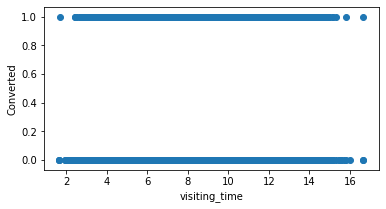

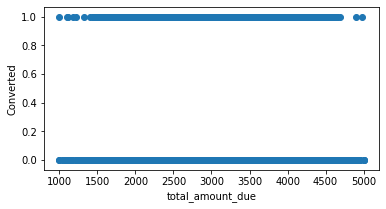

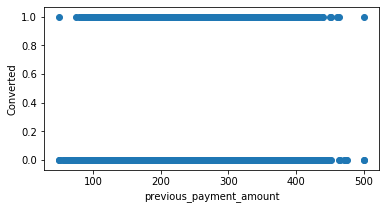

In [264]:
continuous = [df.visiting_time, df.total_amount_due, df.previous_payment_amount]
for x in continuous:
    print(f'{x.name}: {x.mean()} \n')
    scatterContinous(x, df.converted)

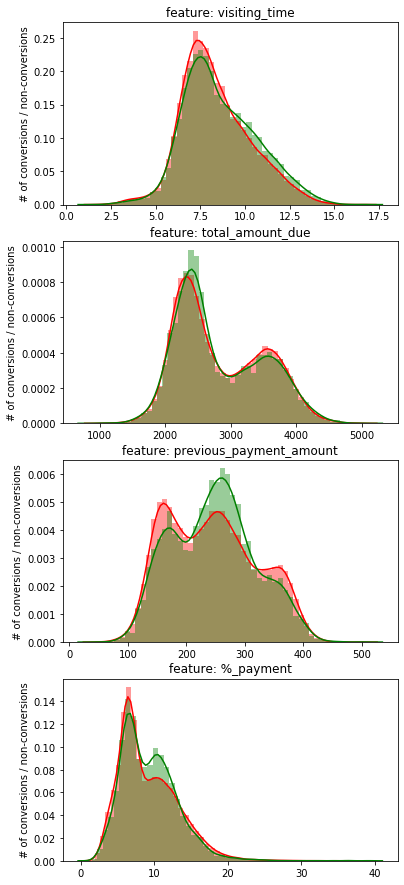

In [265]:
import seaborn as sns
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(viz_df[viz_df.iloc[:,0:4].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(viz_df[col][viz_df.converted == 0], kde=True, bins=50, color='r')
    sns.distplot(viz_df[col][viz_df.converted == 1], kde=True, bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_ylabel('# of conversions / non-conversions')
    ax5.set_title('feature: ' + str(col))
plt.show()

## Decision Tree Classifier

### Feature Engineering: LabelEncoder or Get_Dummies

In [266]:
encode = df
le = LabelEncoder()
encode['browser'] = le.fit_transform(df.browser)
encode['day_of_week'] = le.fit_transform(df.day_of_week)
encode['campaign'] = le.fit_transform(df.campaign)
encode['traffic_source'] = le.fit_transform(df.traffic_source)

# encode = pd.get_dummies(df)
# encode = encode.drop('%_payment', axis=1)
encode.head(10)

,browser,visiting_time,total_amount_due,previous_payment_amount,previous_visitor,day_of_week,campaign,converted,traffic_source,%_payment
0,0,6.81,2514.980300,210.646360,0,4,0,0,1,8.3757
1,0,6.85,2127.218600,124.013649,0,4,0,0,1,5.8298
2,0,7.16,1958.818180,220.467136,0,4,0,0,1,11.2551
3,0,6.26,1718.324561,206.429885,0,4,0,0,1,12.0134
4,0,7.11,2242.363328,154.405074,0,4,0,0,1,6.8858
5,0,8.09,2434.856839,255.384047,0,4,0,0,1,10.4887
6,0,6.71,2264.652882,289.612899,0,4,0,0,1,12.7884
7,0,6.48,1935.035712,169.077405,0,0,0,0,1,8.7377
8,0,7.05,2490.579015,137.652765,0,0,0,0,1,5.5269
9,0,7.06,2255.269345,219.177327,0,4,0,0,1,9.7185


In [267]:
X = encode.drop('converted', axis=1) #['converted', 'visiting_time', 'total_amount_due', 'previous_payment_amount']
y = encode['converted'].values

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

DTC = DecisionTreeClassifier()

In [269]:
DTC = DTC.fit(X_train, y_train)

print('Train Accuracy Score:', DTC.score(X_train, y_train))
print('Test Accuracy Score:', DTC.score(X_test, y_test))

Train Accuracy Score: 1.0
Test Accuracy Score: 0.7640555555555556


In [270]:
y_pred = DTC.predict(X_test)

In [271]:
confusion_matrix(y_test, y_pred)

array([[13345,  2278],
       [ 1969,   408]])

In [272]:
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,13345,2278,15623
1,1969,408,2377
All,15314,2686,18000


In [273]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     15623
           1       0.15      0.17      0.16      2377

   micro avg       0.76      0.76      0.76     18000
   macro avg       0.51      0.51      0.51     18000
weighted avg       0.78      0.76      0.77     18000



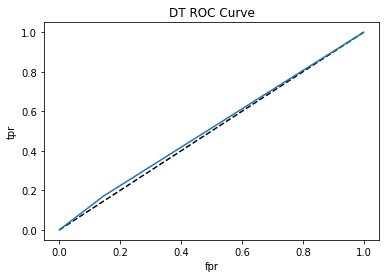

In [274]:
y_pred_proba = DTC.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label='KNN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('DT ROC Curve')
plt.show()

In [275]:
roc_auc_score(y_test, y_pred_proba)

0.5129171334099044

In [276]:
X_Retrain, X_Retest, y_retrain, y_retest = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [277]:
DTC = DTC.fit(X_Retrain, y_retrain)

print('Train Accuracy Score:', DTC.score(X_Retrain, y_retrain))
print('Test Accuracy Score:', DTC.score(X_Retest, y_retest))

Train Accuracy Score: 1.0
Test Accuracy Score: 0.7783333333333333


## The Train-Test Accuracy is Overfit. 

In [278]:
del df, encode
gc.collect()

67298

In [279]:
features = X.columns
dot_data = StringIO()
export_graphviz(DTC, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=features, class_names=['Not Converted','Converted'])

In [ ]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png('Conversion_Path.png')
Image(graph.create_png())

In [281]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=6)
dtc = dtc.fit(X_train, y_train)
print('Train Accuracy Score:', dtc.score(X_train, y_train))
print('Test Accuracy Score:', dtc.score(X_test, y_test))

Train Accuracy Score: 0.8706904761904762
Test Accuracy Score: 0.8667222222222222


In [282]:
y_pred = dtc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[15594,    29],
       [ 2370,     7]])

In [283]:
pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Real,,,
0,15594,29,15623
1,2370,7,2377
All,17964,36,18000


In [284]:
y_pred_proba = dtc.predict_proba(X_test)[:,1]

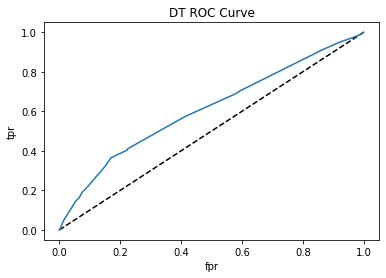

In [285]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label='KNN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('DT ROC Curve')
plt.show()

In [286]:
roc_auc_score(y_test, y_pred_proba)

0.6102237241183868

In [287]:
gc.collect()

2488